In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

In [2]:
import time
import numpy as np
import sympy as sym
from scipy.optimize import fsolve, least_squares
from scipy import special
from itertools import combinations, permutations
import matplotlib.pyplot as plt
from matplotlib import lines
import matplotlib.gridspec as gridspec
import lmfit as lmf
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import IPython.display as disp
import IPython.display as disp
from ipywidgets import interactive, fixed

import IntroBox_class as ib

c_speed = 299792458

#path_fig = 'C:/Users/crbr/Dropbox/Postdoc/projects/introbox/figures/'

# Introduction to Gaussian beam calculations

A Gaussian beam is defined by its wavelength $\lambda$, the refractive index n of the medium in which it travels and any of the three parameters:

> Waist size: $\omega_0 = \sqrt{\frac{\lambda z_R}{\pi n}} = \frac{\lambda}{\pi n \theta}$ <br>
> Rayleigh length: $z_R = \frac{\pi n \omega_0^2}{\lambda} = \frac{\lambda}{\pi n \theta^2}$ <br>
> Divergence angle: $\theta = \frac{\lambda}{\pi n \omega_0} = \sqrt{\frac{\lambda}{\pi n z_R}}$

The waist size is defined as the radius of the beam at the focal point, the Rayleigh length is defined is the distance from the focal point to the point where the beam width has expanded by a factor $\sqrt{2}$ and the divergence angle is defined as the angle at which the beam width linearly expands away from the focal point. As seen from the definitions all three parametes are mutually dependent: a tighter focused beam will have a smaller waiste size, a smaller rayleigh length and a steeper divergence angle.

Away from the focus, the spotsize paraemeter $\omega(z)$ and the radius of the constant phase wavefronts front $R(z)$ of the beam are computed as:

> $\omega(z)=\omega_0 \sqrt{1 + \left( \frac{z}{z_R} \right)^2}$ <br>
> $R(z) = z \left(1 + \left( \frac{z_R}{z} \right)^2 \right)$,

where $\omega(z)$ is defined as the half width at $1/e^2$ maximum of the Gaussian intensity distribution, corresponding to approximatly 1.7 FWHM. With these parameters it can be usefull to desribe the Gaussian beam by it's complex q-parameter, which at any point along the optical z-axis fully defines the beam:

>$q(z) = z + i z_R \; \Leftrightarrow \; \frac{1}{q(z)} = \frac{1}{R(z)} + i\frac{\lambda}{\pi n \omega(z)^2}$ 

In [3]:
bp = ib.beamplots()

interactive_plot = interactive(bp.plot, w0 =(1, 16, 1), n=(1, 4, 1))
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(IntSlider(value=8, description='w0', max=16, min=1), IntSlider(value=2, description='n',…

## Determining the waist size and waist position

Since a Gaussian beam is fully determined by it's linear expansion, it would in principle be enough to measure the beam width at a few points far away from the focus in order to determine the divergence angle and from that calculate the beam waist. But in practice one often also wants to know the preciese location of the focus, which can be harde to judge by hand. A better results is therefore often obtained by measuring the beam width at equally spaced points both before and after the focus and then fitting the spotsize parameter function $\omega(z)$ to those measurements, in order to estimate the waist size $\omega_0$ and waist position $z_0$. The width of the beam is often determined using a <b>knifeedge measurrement</b>.

We can still perform a linear fit of the data points collected away from the focal point in order to estimate the divergence angle. From the divergence angle and waist size we can compute the <b>beam parameter product</b> (BPP) of the Gaussian beam as $BPP = \omega_0 \theta$ and compare it to the theoretical BPP if a an ideal Gaussian beam of the same wavelength. This comparison is expressed through the M-squared parameter as the ratio between the measured BPP and ideal BPP $M^2 = \omega_0 \theta / \frac{\lambda}{\pi n}$. Real laser beams will always have $M^2 > 1$.

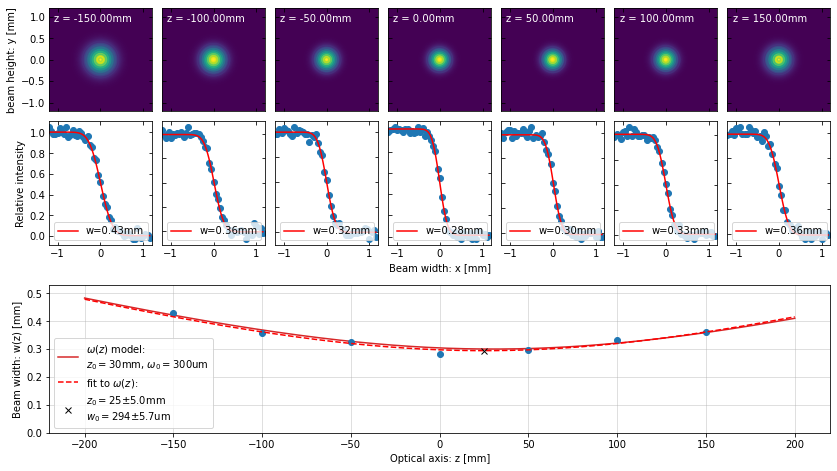

In [4]:
w0 = 0.3
z0 = 30
r = 1.2

b = ib.beam(w0,z0)
mm = ib.modematching()
zs = np.linspace(-200,200,201)
ws = b.w(zs)

z_ne = np.array([-150,-100,-50,0,50,100,150])
#z_ne = np.array([-150,-50])
n_ne = len(z_ne)
w_ne=np.zeros(n_ne)

# ---- Plotting -----

fig = plt.figure(figsize=(2*n_ne,8))
gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[5,3], hspace=0.2)
gs1 = gs[0].subgridspec(2, n_ne, wspace=0.1, hspace=0.0)
gs2 = gs[1].subgridspec(1,1)

ax10 = [fig.add_subplot(gs1[0,i]) for i in range(n_ne)]
ax11 = [fig.add_subplot(gs1[1,i]) for i in range(n_ne)]
ax2 = fig.add_subplot(gs2[0])

for i,k in enumerate(z_ne):
    mat,xs,ys = b.cross(k, r=r, steps=True)
    ax10[i].imshow(mat, alpha=1, extent=[-r,r,-r,r])
    ax10[i].contour(xs,ys,mat)
    ax10[i].text(0.9*(-r),0.75*r, f'z = {k:.2f}mm', color='w')
    
    dx=0.05
    x = np.arange(-r,r,dx)
    noise = np.random.normal(0, 0.03, len(x))
    data = b.simdata_crosscut1(k, dx, r=r) + noise
    x0,w_ne[i],fitx, fity = mm.cross_fit(x, data, sub_offset=True, plot=False)
    ax11[i].plot(x, data, 'o')
    ax11[i].plot(fitx, fity, 'r', label=f'w={w_ne[i]:.2f}mm')
    
ax2.plot(zs,ws, 'C3', label='$\omega(z)$ model: \n$z_0=${:.0f}mm, $\omega_0=${:.0f}um'.format(z0,w0*1e3))  
    
fit_val,fit_stderr = mm.beam_fit(z_ne, w_ne, guess=[0,0.1], plot=False)    
fit_label = (r'$z_0=${:.0f}$\pm${:.1f}mm'.format(fit_val[0], fit_stderr[0]) + '\n' + 
              r'$w_0=${:.0f}$\pm${:.1f}um'.format(fit_val[1]*1e3, fit_stderr[1]*1e3))
ax2.plot(z_ne,w_ne, 'o')
ax2.plot(zs, mm.w(zs-fit_val[0],fit_val[1]), 'r--', label=r'fit to $\omega(z)$:')
ax2.plot(fit_val[0], fit_val[1], 'kx', label=fit_label)


for i in range(n_ne):
    ax10[i].get_xaxis().set_ticklabels([])
    ax10[i].tick_params(direction='in', top=True, right=True)
    ax11[i].tick_params(direction='in', top=True, right=True)
    ax11[i].set_xlim(-r,r)
    ax11[i].legend(loc=3)
    
for i in range(n_ne-1):
    ax10[i+1].get_yaxis().set_ticklabels([])
    ax11[i+1].get_yaxis().set_ticklabels([])

ax10[0].set_ylabel('beam height: y [mm]')
ax11[0].set_ylabel('Relative intensity')
ax11[int(n_ne/2)].set_xlabel('Beam width: x [mm]')

ax2.grid(alpha=0.5)
ax2.set_ylim(0,1.1*ws.max())
ax2.legend(loc=3)
ax2.set_ylabel('Beam width: w(z) [mm]')
ax2.set_xlabel('Optical axis: z [mm]')

plt.show()

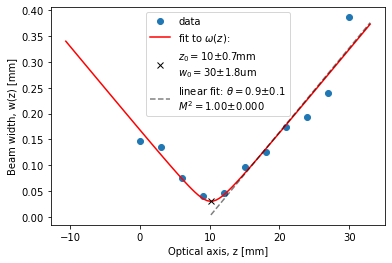

In [5]:
x = np.linspace(0,30,11)
noise = np.random.normal(1, 0.1, 11)
mm = ib.modematching(lam=1550e-6)
data = mm.w(x-10,0.03)*noise

_,_ = mm.beam_fit(x, data, guess=[-500,0.1], plot=True)

## Calculating lense positions for mode matching



### Matrix transfer analysis
The transformation of a Gaussian beam by a combination linear optical elements is described by the ABCD law
> $q_2 = \frac{Aq_1 + B}{Cq_1 + D}$

where $q_1$ is the initial Gaussian beam parameter, $q_2$ is the resulting beam parrameter and A,B,C and D are the matrix elements of the 2x2 ray transfer matrix $M = M_n...M_3M_2M_1$ describing the sequential transformation of n linear optical elements 1 → 2 → 3 → ... → n. The individual matricies describing the most common transformations are given below:

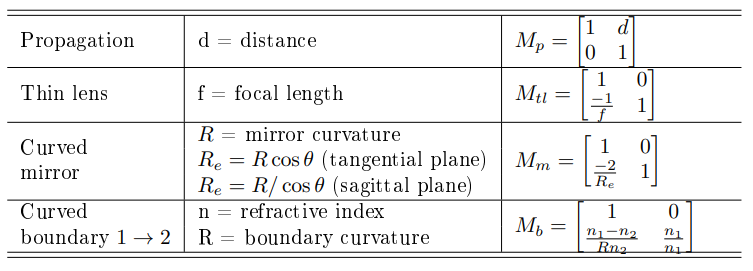

### Waist-to-waist transfer
If we say that both $q_1 = i z_{R,1}$ and $q_2 = i z_{R,2}$ are waists, we can then use the ABCD law to write

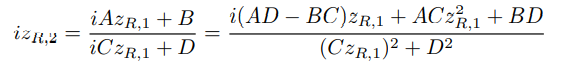

which is solved by separating the real and complex part

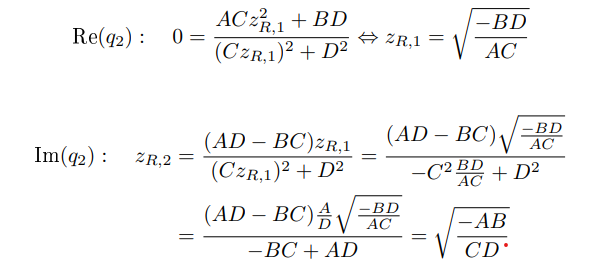

We now have two equations valid for waist-to-waist tranfer scenarios:
> $z_{R,1} = \sqrt{-\frac{BD}{AC}}$ <br>
> $z_{R,2} = \sqrt{-\frac{AB}{CD}}$

and we will see that they can be used to solve a number of practical challanges when designing free space optical setups.

#### Scenario 1 - Known waist and lense placement

In the scenario of having a known waist size and location and placing a lense at a specific distance, we can solve the w2w equations to find the position and size of the waist after the lense

In [4]:
mm = ib.modematching()

def match_df_int(w01,d1,i):
    fs = np.array([25,50,75,100,125,150,200,300])
    w02, d2 = mm.match_df(w01,d1,fs[i],plot=True)
    print(fs[i], d2, w02)
    plt.xlim(0,100)
    plt.ylim(0,0.5)
    plt.show()


interactive_plot = interactive(match_df_int, w01 =(0.01,0.2,0.01), d1=(10,100,5), i=(0,7,1))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

#mm.match_df(w01=0.3,d1=40, f1=200, plot=True) 

interactive(children=(FloatSlider(value=0.09999999999999999, description='w01', max=0.2, min=0.01, step=0.01),…

#### Scenario 2 - Known waist and target waist size with single lense

In the scenario of having a known waist and a desired target waist size, we can use a single lense and solve the w2w equations to calculate the neccesary position of that lens and the resulting location of the desired waist.

-=[ Solutions ]=-
f100: [338.2, 464.6]mm
f150: [561.4, 757.1]mm
f200: [771.6, 1035.1]mm


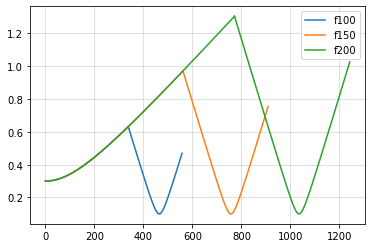

In [7]:
pams = np.array([0.3,0.1])
lenses = np.array([100,150,200])

mm = ib.modematching()
mm.match_1f(pams,lenses, plot=True) 

#### Scenario 3 - Known waist and target size and position with two lenses

In the scenario of having a known waist and a desired target waist size and position, we need to use two lenses and then solve the w2w equations to calculate the neccesary positions of them to get the result target waist.

-=[ Solutions ]=-
f(100, 150): [36.0, 374.5]mm
f(100, 200): None
f(150, 100): [227.2, 565.7]mm
f(150, 200): None
f(200, 100): None
f(200, 150): [91.0, 481.3]mm, [309.0, 618.7]mm


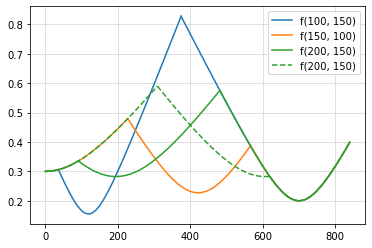

In [8]:
pams = np.array([0.3,0.2,700])
lenses = np.array([100,150,200])
mm = ib.modematching()
mm.match_2f(pams,lenses, plot=True) 

## Finding resonant cavity geometries

In the above scenarios we always knew the starting and ending waist sizes ($q_1$ and $q_2$) and simply used the w2w equations to calucalte the required ABCD matrix. But it is also possible to use the equations in the oppesite fashion when desinging the geometry of an optical cavity.

#### Optical cavity

In order to form an optical cavity one needs to ensure that the optical field resonating inside inteferes constructively with itself. A requirement for this is that the beam should overlap itself perfectly after a single roundtrip of the cavity. In other words $q_1 = q_2$ after one roundtrip. We can therefore use the w2w equations to calucalte the waist size(s) of the resonant mode supported by a specific cavity geometry. And since the w2w equations are only valid for a scenario that describes waist-to-waist transfer, then any cavity geometry (ABCD matrix) that results in complex waist sizes when solved corresponds to no resonant mode being supported.

As an example is here the result of calculating variou possible configurations of a triangle filter cavity:

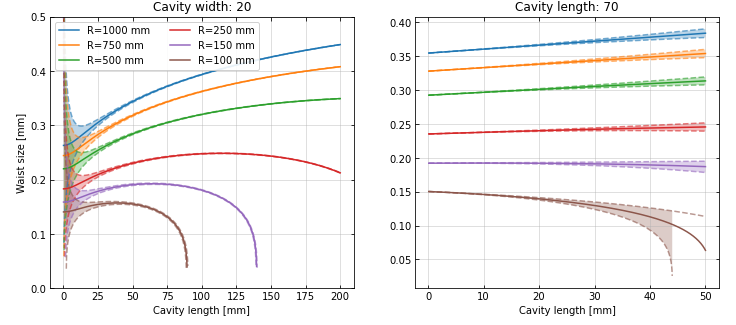

#### Defining a cavity type and geometry

Using the *Cavity_builder* class it is possible to define a cavity geometry based on its type and form. The specific geometries are hardcoded within the class and so far the possible types are 'nl' and 'filter' corresponding to a cavity with or without a nonlinear crystal inside and the possible forms are 'linear', 'triangle' and 'bowtie'. 

A cavity class instance is defined as **cav = Cavity_Builder(type, form)** and information about the required parameters can then be shown with **cav.info()**. To fully define a cavity it is neccesary to define both its geometry paremeters (which sets the ACBD matrix used to calculate the resonant mode) and parameters describing the mirrors, which are used to calculate the bandwidth, finesse and escape efficiency. They are set individually using the funtions **cav.set_geometry(pam=[...])** and **cav.set_optics(pam=[...])**.

To visualize the resulting cavity geometry the *Cavity_plotter* class can be used. It is defined with the cavity instance as input and the plot is created using the **plot_TYPE_FORM()** function, where TYPE and FORM should be the type and form used to initially define the cavity instance. It is then also possible to write a simple interactive function, which prints and plots a the desired cavity specs and geometry with handles for selected parameters.

In [9]:
cav = ib.Cavity_Builder('nl', 'bowtie')
cav.info()

Geometry parameters are:
 (0) crystal length [mm]
 (1) crystal refractive index
 (2) spacing between curved mirrors: d1 [mm]
 (3) spacing between flat mirrors: d2 [mm]
 (4) bowtie height: h [mm]
 (5) mirror curvature: R [mm]
 (6) astigmatism included [none, v, h]

Optics parameters are:
 (0) output coupler reflection: 1-T_out
 (1) input coupler reflection: 1-T_in
 (2) M3 reflection
 (3) M4 reflection
 (4) Additional internal cavity loss: L

         <- - - - -> d1       

    M3,R /--[###]--\ M4,R     ___  
          \       /            |   
            \   /              |   
              X                |   
             / \               | h 
           /     \             |   
    T_in /         \ T_out     |   
   ----\-------------/----->  _|_  

       <- - - - - - -> d2          


Geometry specs:
optical cavity length        316.29 mm
cavity roundtrip time          1.06 ns
folding angle                  6.05 deg
1st waist size                26.77 um
2nd waist size               448.06 um

Optics specs:
free spectral range          947.85 MHz
bandwidth                      7.97 MHz
finesse                       57.97 
intra cavity loss              0.30 %
escape efficiency             97.09 %


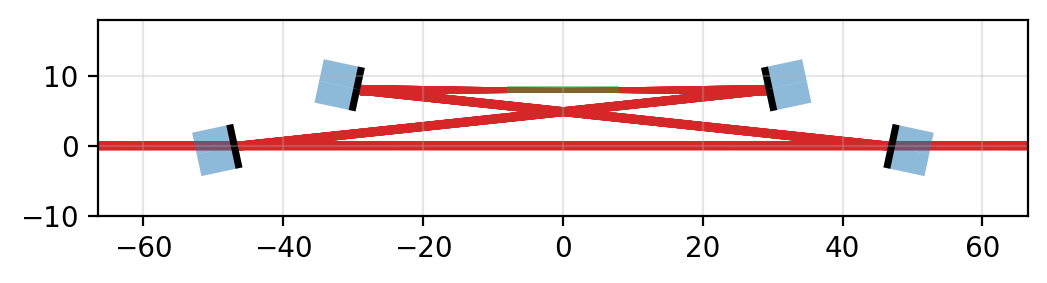

In [10]:
cav = ib.Cavity_Builder('nl', 'bowtie')
#cavity.info()
cav.set_geometry(pam=[16,1.84,58,93,8,50,'none'])
cav.set_optics(pam=[0.9,1,1,1,0.003])

cav.print_specs()

cp = ib.Cavity_Plotter(cav)
cp.plot_nl_bowtie()
#cp.plot_nl_bowtie(lims=[[-10,10],[7,9]])

In [5]:
cav = ib.Cavity_Builder('nl', 'bowtie')

def intplot(cav, d1, d2, h, R):
    cav.set_geometry(pam=[16,1.82,d1,d2,h,R,'none'])
    cav.set_optics(pam=[0.9,1,1,1,0.003])

    cp = ib.Cavity_Plotter(cav)
    cp.plot_nl_bowtie(lims=[[-100,100],[-5,15]], axis_scaling='scaled')
    #cp.plot_nl_bowtie(lims=[[-100,100],[-5,15]], axis_scaling='auto')
    
    cav.print_specs()

interactive_plot = interactive(intplot, cav=fixed(cav), d1=(50, 70, 1), d2=(40, 160, 5), h=(4,12,1), R=(25,75,5))
output = interactive_plot.children[-1]
output.layout.width = '1600px'
interactive_plot

interactive(children=(IntSlider(value=60, description='d1', max=70, min=50), IntSlider(value=100, description=…

In [12]:
cav = ib.Cavity_Builder('filter', 'triangle')
cav.info()

Geometry parameters are:
 (0) triangle width: w [mm]
 (1) triangle height: h [mm]
 (2) mirror curvature: R [mm]
 (3) astigmatism included [none, v, h]

Optics parameters are:
 (0) output coupler reflection: 1-T_out
 (1) input coupler reflection: 1-T_in
 (2) M3 reflection
 (3) Additional internal cavity loss

              __ M3,R         ___ 
              /\               |  
             /  \              |  
            /    \             |h 
           /      \            |  
     T_in /        \ T_out     |  
    -----\----------/----->   _|_ 

         <- - - - - > w         


Geometry specs:
optical cavity length        181.25 mm
cavity roundtrip time          0.60 ns
folding angle                  7.13 deg
waist size                   119.93 um

Optics specs:
free spectral range         1654.07 MHz
bandwidth                      5.42 MHz
finesse                      151.74 
intra cavity loss              2.10 %
escape efficiency             48.80 %


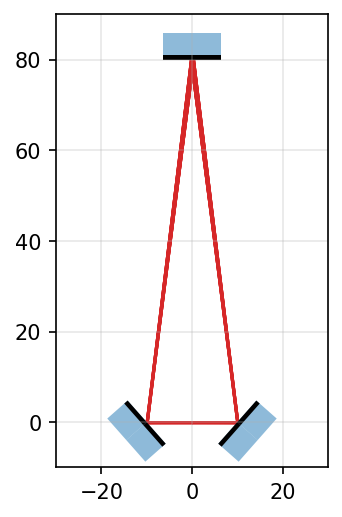

In [6]:
cav = ib.Cavity_Builder('filter', 'triangle')
#cav.info()
cav.set_geometry(pam=[20,80,100,'none'])
cav.set_optics(pam=[0.98,0.98,1, 0.001])

cav.print_specs()

cp = ib.Cavity_Plotter(cav)
cp.plot_filter_triangle()

In [11]:
def intplot(cav, w, h, R):
    cav.set_geometry(pam=[w,h,R,'none'])
    cav.set_optics(pam=[0.98,0.98,1, 0.001])

    cp = ib.Cavity_Plotter(cav)
    cp.plot_filter_triangle(lims=[[-60,60],[-10,110]])
    
    cav.print_specs()

interactive_plot = interactive(intplot, cav = fixed(cav), w=(10, 100, 10), h=(10, 100, 10), R=(50, 1000, 50))
output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

interactive(children=(IntSlider(value=50, description='w', min=10, step=10), IntSlider(value=50, description='…

Geometry specs:
optical cavity length         24.20 mm
cavity roundtrip time          0.08 ns
waist size                    97.05 um

Optics specs:
free spectral range        12388.12 MHz
bandwidth                    103.15 MHz
finesse                       58.52 
intra cavity loss              0.20 %
escape efficiency             98.04 %


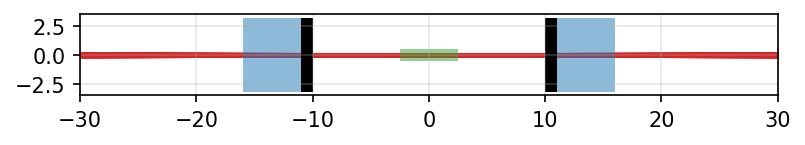

In [15]:
cav = ib.Cavity_Builder('nl', 'linear')
#cav.info()
cav.set_geometry(pam=[5,1.84,20,50])
cav.set_optics(pam=[0.9,0.998,0.00])

cav.print_specs()

cp = ib.Cavity_Plotter(cav)
cp.plot_nl_linear()

In [20]:
def intplot(cav, lcry, d, R):
    cav.set_geometry(pam=[lcry, 1.84, d, R])
    cav.set_optics(pam=[0.9,0.998,0.000])

    cp = ib.Cavity_Plotter(cav)
    cp.plot_nl_linear(lims=[[-30,30],[-1,1]], axis_scaling='auto')
    
    cav.print_specs()

interactive_plot = interactive(intplot, cav = fixed(cav), lcry=(1, 20, 1), d=(10, 50, 2), R=(20, 100, 5))
output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

interactive(children=(IntSlider(value=10, description='lcry', max=20, min=1), IntSlider(value=30, description=…